In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl

from fetch_housing_data import HOUSING_PATH

%matplotlib inline
plt.style.use('seaborn')

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

## Quick Glance at the Data

In [4]:
housing = load_housing_data()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


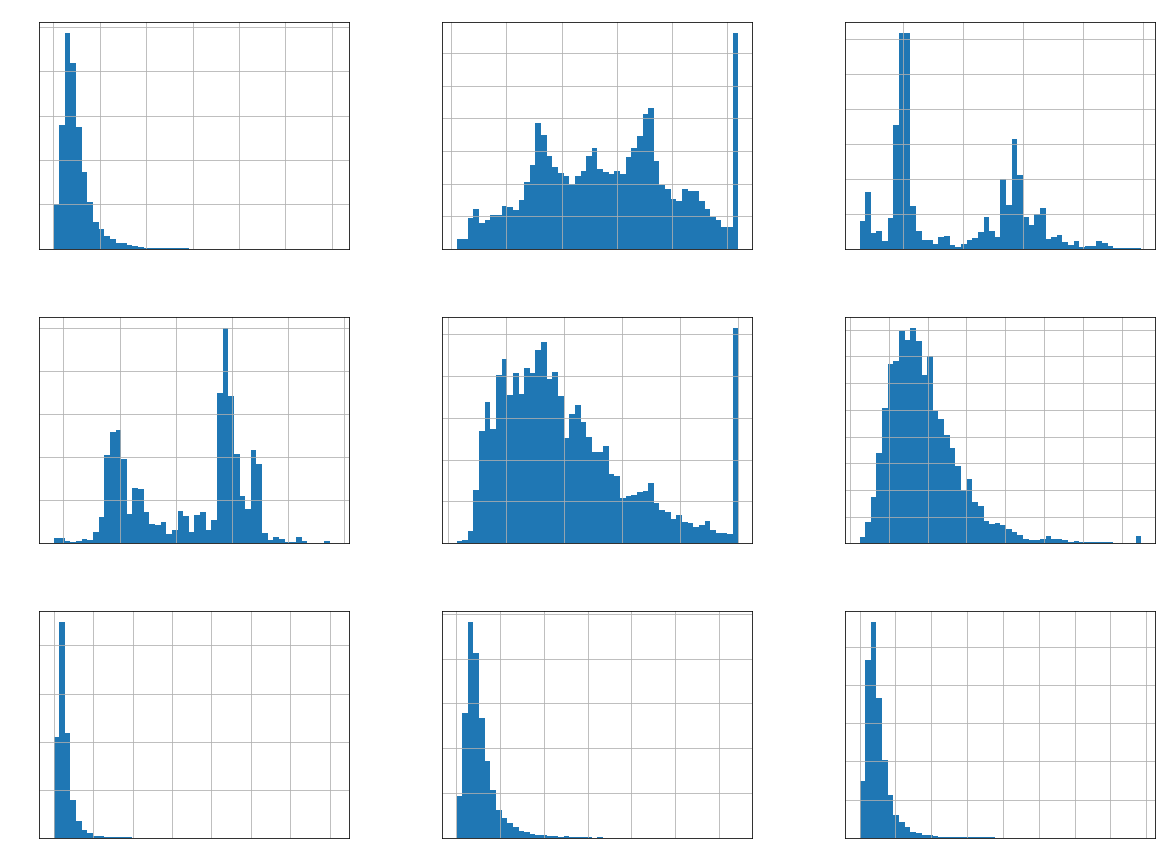

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Creating a Test Set

The code below splits the dataset into a training and test set. 

It also implements a hash check before the split, so that if the data is updated after initial training, it keeps the same test set as previously used and adds some of the newly updated values to it. Thus if the data is updated, the model will never see any of the data in the test set.

In [10]:
from zlib import crc32

def test_set_check(identifies, test_ratio):
    return crc32(np.int64(identifies)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [11]:
df_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, 'index')
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 16512
Test set size: 4128


To ensure different median incomes are equally represented, we will bin them

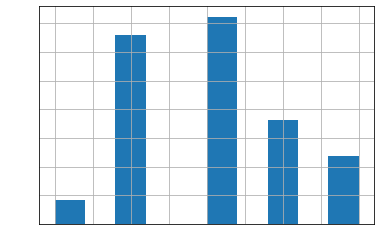

In [12]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1,2,3,4,5])
housing['income_cat'].hist()

And then we will perform stratified sampling. The population is divided into homogeneous subgroups and the correct number of instances are sampled from each stratum to guarantee the test set is representative of the overall population

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Now, what are the proportions of each income category on the test set? Just b looking at the histogram we can see that the proportions are roughly similar

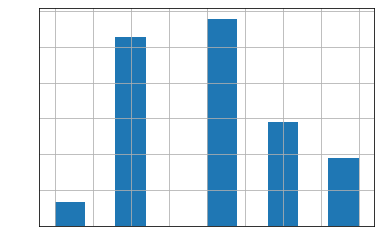

In [14]:
strat_train_set['income_cat'].hist()

But we can evaluate the actual proportions in more detail also

In [15]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Exercise: Recreate the table in the book

Finally we should remove the categories just created to return the dataset to its original state

In [16]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploring the data

In [17]:
housing = strat_train_set.copy()

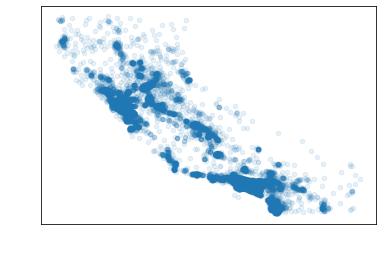

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

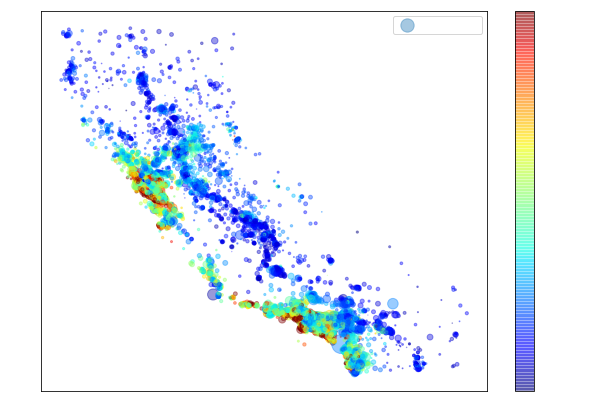

In [19]:
housing.plot(
    kind='scatter', x='longitude', y='latitude', alpha=0.4,
    s=housing['population']/100, label='population', figsize=(10,7),
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
)
plt.legend()

Coastal areas (red) are more expensive and population density also plays a role in the house price

### Looking for Correlations

In [20]:
corr_matrix = housing.corr()

In [21]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

There's a slight correlation between price and latitude, meaning prices go slightly down as we go north

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff04ad6fb00>,
      dtype=object)

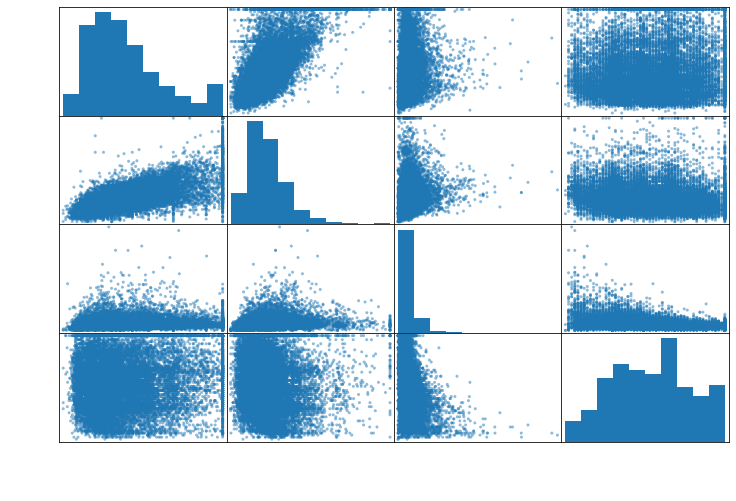

In [22]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

Median income seems to be the most promising attribute, let's zoom in

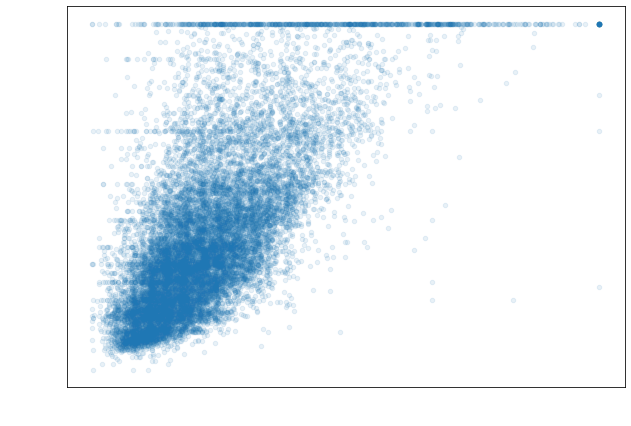

In [23]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', 
             alpha=0.1, figsize=(10,7))

Note that because the data is capped at 500k, we have a horizontal line at the top. If you look closely enough, you will also notice some horizontal lines around 450k, 350k and others. We might want to exclude these to prevent our algorithm to learning these quirks

Number of rooms per district is not very useful by itself, but # of rooms per house is more interesting.

Similarly, # of bedrooms per district is not interesting, but # of bedrooms compared to the # of rooms is more interesting

In [24]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Data Cleaning

Before preparing the data for modelling, let's revert to a clean training set by copying strat_train_set. We'll also separate the predictors and labels.

In [26]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

The attribute total bedrooms had some null values. We'll impute the median value to fill these values. Note we are storing the median values calculated on the training set if we need to impute values on the test set later

In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

The sklearn imputer only  works on numerical values, so let's drop the only object we have in the DF

In [28]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [29]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [30]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index=housing_num.index)

In [31]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


Let's turn our attention to the categorical variable and encode it into a numerical variable

In [32]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat = housing[['ocean_proximity']]
housing_cat_encoded = cat_encoder.fit_transform(housing_cat)
housing_cat_encoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Now we have a sparse Matrix where each non-zero entry corresponds to pertaining to one of the above categories

Let's combine the feature selection into a single class, creating a custom ScikitLearn transformer

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [35]:
att_adder = CombinedAttributesAdder(False)
housing_extra_attribs = att_adder.transform(housing.values)

## Feature Scaling

As we are using numerical variables with different ranges (e.g. # of rooms (6-39320) and median income (0,15)) our algorithms won't perforn as well. Scaling helps us get around this. We can perform Standard Scaling or Normalisation Scaling.

**Normalization** works by subtracting the minimum value and dividing by maximum - min.

The resulting data ranges between 0 and 1

In [36]:
from sklearn.preprocessing import MinMaxScaler

**Standardization** is transforming the variable into a standard normal variable, by subtracting the mean and dividing by the standard deviation.

The data is not bound between a range but this method is less sensitive to outliers

In [37]:
from sklearn.preprocessing import StandardScaler

***NOTE*** It is important that you fit the scaler to the *training set* only and then fit the training and test set

## Transformation pipelines

We can combine the various steps in preparing the data into a pipeline, so that when the data is refreshed, we can easily re-run the process

In [38]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Now let's create a pipeline for our categorical variable and combine the two

In [39]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# Selecting and training a model

Let's start by applying a simple linear regression

In [40]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now let's test it on a small subset of data

In [41]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [42]:
print(f"Predictions {lin_reg.predict(some_data_prepared)}")

Predictions [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [43]:
print(f"Labels {list(some_labels)}")

Labels [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let's measure the Mean Squared Error of our prediction

In [44]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Model is poorly underfitting the data, let's try a Decision Tree

In [45]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Looks like the Decision Tree is overfitting the data. But how can we be sure? We could split the training set into training and validation set as discussed in chapter 1.

One better way to do it is using K-fold cross validation. This randomly splits the training set into K distinct subsets called folds. Then it trains a model K times on K-1 subsets leaving the last for validation. The result is an array containing the evaluation scores

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [47]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")
    
display_scores(tree_rmse_scores)

Scores: [69531.39423352 67969.46589902 69919.94883597 68868.61398025
 72067.1735467  74599.50742368 71154.58642217 70709.64383646
 78376.71692582 69372.68873017]
Mean: 71256.97398337602
Standard Deviation: 2960.7011288451436


In [48]:
lin_scores = np.sqrt(
                -cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10))
display_scores(lin_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798348


By comparing the results, it is easy to see the Decision Tree model is overfitting the data and performing worse than the Linear Regression

Let's give one more model a try with a Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, forest_predictions))
forest_rmse

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22137.60385803271

In [50]:
forest_scores = np.sqrt(-cross_val_score(forest_reg, housing_prepared, housing_labels,
                                        scoring='neg_mean_squared_error', cv=10))

In [51]:
display_scores(forest_scores)

Scores: [52457.45616485 50780.83738804 54295.28523642 54467.68593831
 52395.20458221 55547.46461634 53605.1095978  50548.42906339
 54973.078421   52289.9063168 ]
Mean: 53136.04573251584
Standard Deviation: 1627.7223535065848


While the results are better, note that the score produced by the model is still lower than the ones with k-fold validation, meaning the model is still overfitting the training data

We can explore some solutions to the overfitting (simplify the model, regularize it, get more training data, etc..) but before doing that we should try many other models (e.g. SVM, neural net) to see how each performs on the data and create a shortlist of potential models (usually 2 to 5 models)

## Fine Tuning a model

## Grid Search
Instead of having to manually tweak and change the parameters of a model, we can use GridSearchCV to automatically try all possible combinations of parameters defined in param_grid, train the models and select the best performing.

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [53]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [54]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64860.096498664934 {'max_features': 2, 'n_estimators': 3}
55769.31292787504 {'max_features': 2, 'n_estimators': 10}
52918.159353710165 {'max_features': 2, 'n_estimators': 30}
60740.61874452272 {'max_features': 4, 'n_estimators': 3}
52843.30325737716 {'max_features': 4, 'n_estimators': 10}
50301.96497931483 {'max_features': 4, 'n_estimators': 30}
59760.11588745596 {'max_features': 6, 'n_estimators': 3}
52436.89182176932 {'max_features': 6, 'n_estimators': 10}
50264.15367706605 {'max_features': 6, 'n_estimators': 30}
58843.49498192927 {'max_features': 8, 'n_estimators': 3}
51743.71517158765 {'max_features': 8, 'n_estimators': 10}
49901.78455826427 {'max_features': 8, 'n_estimators': 30}
62612.67926652695 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54616.54163985332 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60239.58584546956 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52686.460635304706 {'bootstrap': False, 'max_features': 3, 'n_estimators':

If the search space of parameters is big, we can instead use RandomizedSearchCV to try all possible combinations of parameters, given a number of iterations

For a Random Forest, we can look at the feature importance of the parameters and try dropping some of the less informative ones

In [56]:
feature_importance = grid_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importance, attributes), reverse=True)

[(0.36806004160173367, 'median_income'),
 (0.14874852445491513, 'INLAND'),
 (0.11413596559807425, 'pop_per_hhold'),
 (0.07623644539153032, 'longitude'),
 (0.06871728735422976, 'latitude'),
 (0.05714867510000696, 'bedrooms_per_room'),
 (0.04892874568959249, 'rooms_per_hhold'),
 (0.040872237364820055, 'housing_median_age'),
 (0.015370404568125742, 'total_rooms'),
 (0.01506344156772305, 'population'),
 (0.014659752973633103, 'total_bedrooms'),
 (0.013831872329669764, 'households'),
 (0.011220332627453294, '<1H OCEAN'),
 (0.004176977406994352, 'NEAR OCEAN'),
 (0.002735020647251429, 'NEAR BAY'),
 (9.427532424667638e-05, 'ISLAND')]

Out of the categorical variables, only one value seems to affect the house pricing. We could try dropping the other values

Once we're happy with the parameters, we can test the model on the test data

In [57]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [58]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47740.496450571285

We can also get a 95% confidence interval to evaluate the precision of the error

In [59]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45762.95492385, 49639.3186832 ])

# Exercises

### 1) Try using SVR with various kernels and various values for C hypterparameter. How does the best SVR predictor perform?

In [70]:
print(f'Train set size {len(housing_prepared)}')
print(f'Test set size {len(X_test)}')

Train set size 16512
Test set size 4128


In [71]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(housing_prepared, housing_labels)
svr_predictions = svr.predict(X_test_prepared)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [72]:
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

116919.73658094219

RMSE of 116k with the default parameters, that's double of the random forest! Let's try other values

In [83]:
svr_grid = [
    {'kernel':['rbf', 'sigmoid'], 'C': range(1, 3), 'gamma':'scale'},
    {'kernel':['poly'], 'degree': range(2,5) , 'C': range(1,3), 'gamma':'scale'}
]

svr = SVR()

svr_grid_search = GridSearchCV(svr, svr_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

# svr_grid_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': range(1, 5),
                          'kernel': ['rbf', 'linear', 'sigmoid']},
                         {'C': range(1, 5), 'degree': range(1, 6),
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [85]:
svr_grid_search.best_params_

{'C': 4, 'kernel': 'linear'}

In [88]:
best_svr = svr_grid_search.best_estimator_
svr_pred = best_svr.predict(X_test_prepared)

svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_rmse

93689.69188677834

In [89]:
cvres = svr_grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

118634.22435240951 {'C': 1, 'kernel': 'rbf'}
112571.79521013204 {'C': 1, 'kernel': 'linear'}
118529.109317212 {'C': 1, 'kernel': 'sigmoid'}
118356.51196411568 {'C': 2, 'kernel': 'rbf'}
107136.07469854166 {'C': 2, 'kernel': 'linear'}
118146.84028538647 {'C': 2, 'kernel': 'sigmoid'}
118075.55346854207 {'C': 3, 'kernel': 'rbf'}
102396.40414799473 {'C': 3, 'kernel': 'linear'}
117770.69561310227 {'C': 3, 'kernel': 'sigmoid'}
117802.34181812892 {'C': 4, 'kernel': 'rbf'}
98407.80043269071 {'C': 4, 'kernel': 'linear'}
117395.88016115843 {'C': 4, 'kernel': 'sigmoid'}
118497.3820399307 {'C': 1, 'degree': 1, 'kernel': 'poly'}
118851.51976683844 {'C': 1, 'degree': 2, 'kernel': 'poly'}
119008.20520939352 {'C': 1, 'degree': 3, 'kernel': 'poly'}
123007.42459537355 {'C': 1, 'degree': 4, 'kernel': 'poly'}
216706.3150644677 {'C': 1, 'degree': 5, 'kernel': 'poly'}
118080.83361930435 {'C': 2, 'degree': 1, 'kernel': 'poly'}
118782.64620683332 {'C': 2, 'degree': 2, 'kernel': 'poly'}
118826.8617220116 {'C': 

Even after a long time after training with GridSearch, SVR did not perform as well as random forest

### 2) Try using RandomizedSearch instead of GridSearch

In [74]:
from scipy import stats

In [85]:
from sklearn.model_selection import RandomizedSearchCV

svr_grid = {
    'kernel':['rbf', 'sigmoid'], 
    'C': stats.expon(scale=100)
}
svr = SVR()
random_search = RandomizedSearchCV(svr, svr_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [86]:
# random_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7eff0046a0f0>,
                                        'kernel': ['rbf', 'sigmoid']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=0)

In [90]:
random_svr = random_search.best_estimator_
random_svr

SVR(C=269.3482577813486, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='sigmoid', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
random_svr_preds = random_svr.predict(X_test_prepared)

random_rmse = np.sqrt(mean_squared_error(y_test, random_svr_preds))
random_rmse

83732.24904662569

Still not as good as the random forest regressor, but an improvement over the gridsearch

### 3) Try adding a transformer to the preparation pipeline to select only the most important attributes

From our RandomForest Exploration, we found feature importances of our variables, we'll use that as a start

In [92]:
feature_importance = grid_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importance, attributes), reverse=True)

[(0.3531830166084703, 'median_income'),
 (0.16317151823428405, 'INLAND'),
 (0.11688266076493366, 'pop_per_hhold'),
 (0.07511364866076548, 'bedrooms_per_room'),
 (0.06914991397247977, 'longitude'),
 (0.06825353810091031, 'latitude'),
 (0.044999447776848105, 'rooms_per_hhold'),
 (0.04057103444990145, 'housing_median_age'),
 (0.015201416786337196, 'population'),
 (0.015060782052416103, 'total_rooms'),
 (0.01477642686849632, 'total_bedrooms'),
 (0.014603320093401925, 'households'),
 (0.004396820049736327, '<1H OCEAN'),
 (0.0025706587234974694, 'NEAR OCEAN'),
 (0.001970991871631406, 'NEAR BAY'),
 (9.480498589023246e-05, 'ISLAND')]

From the above, let's suppose these are the most important features

In [67]:
important_feats = ['median_income', 'INLAND', 'pop_per_hhold',
                   'bedrooms_per_room', 'longitude', 'latitude']
feats_idx = [i for i, feat in enumerate(attributes) if feat in important_feats]
feats_idx

[0, 1, 7, 9, 10, 12]

Below is the old pipeline as we defined it

In [107]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

We'll create a class that applies the feature selection

In [ ]:
class SelectFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[:, self.feature_indices]

And add it to the transformer

In [ ]:
feat_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('select_feats', SelectFeatures(feats_idx))
])

In [108]:
housing_prep = feat_pipeline.fit_transform(housing)

### 4) Create a pipeline that does the preparation and final prediction

In [114]:
predict_pipeline = Pipeline([
    ('prepare', full_pipeline),
    ('select_feats', SelectFeatures(feats_idx)),
    ('model', RandomForestRegressor())
])

In [126]:
rf = predict_pipeline.fit(housing, housing_labels)

In [132]:
preds = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

50981.824824041614

### 5) Automatically explore some preparation options with GridSearch

In [139]:
param_grid = [{
    'prepare__num__imputer__strategy' : ['mean', 'median', 'most_frequent']
}]

grid_search_prep = GridSearchCV(predict_pipeline, param_grid, cv = 5,
                                scoring='neg_mean_squared_error', verbose=2)

grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] prepare__num__imputer__strategy=mean ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. prepare__num__imputer__strategy=mean, total=   0.5s
[CV] prepare__num__imputer__strategy=mean ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ............. prepare__num__imputer__strategy=mean, total=   0.5s
[CV] prepare__num__imputer__strategy=mean ............................
[CV] ............. prepare__num__imputer__strategy=mean, total=   0.6s
[CV] prepare__num__imputer__strategy=mean ............................
[CV] ............. prepare__num__imputer__strategy=mean, total=   0.5s
[CV] prepare__num__imputer__strategy=mean ............................
[CV] ............. prepare__num__imputer__strategy=mean, total=   0.6s
[CV] prepare__num__imputer__strategy=median ..........................
[CV] ........... prepare__num__imputer__strategy=median, total=   0.6s
[CV] prepare__num__imputer__strategy=median ..........................
[CV] ........... prepare__num__imputer__strategy=median, total=   0.6s
[CV] prepare__num__imputer__strategy=median ..........................
[CV] ........... prepare__num__imputer__strategy=median, total=   0.5s
[CV] prepare__num__imputer__strategy=median ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    8.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('prepare',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                         

In [140]:
grid_search_prep.best_params_

{'prepare__num__imputer__strategy': 'median'}